https://medium.com/@sergeykolchenko/machine-learning-meets-biology-once-again-or-single-cell-rna-sequencing-as-a-field-for-2be24f9108dd

In [1]:
import csv
import gzip
import os
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap #umap-learn
from sklearn.cluster import Birch, AffinityPropagation, DBSCAN, MeanShift, SpectralClustering, AgglomerativeClustering, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from itertools import cycle, islice
%matplotlib inline

In [2]:
matrix_dir = "../data/filtered_feature_bc_matrix"
mat = scipy.io.mmread(os.path.join(matrix_dir, "matrix.mtx"))
mat = np.array(mat.todense())
features_path = os.path.join(matrix_dir, "features.tsv")
annotation  = pd.read_csv(features_path,sep='\t',header=None)
annotation.columns = ['feature_ids','gene_names','feature_types']
barcodes_path = os.path.join(matrix_dir, "barcodes.tsv")
barcodes = [line.strip() for line in open(barcodes_path, 'r')]
print('Matrix dimensionality {}'.format(mat.shape))
mat = mat.T #becase we want (samples,features) matrix

Matrix dimensionality (33555, 7865)


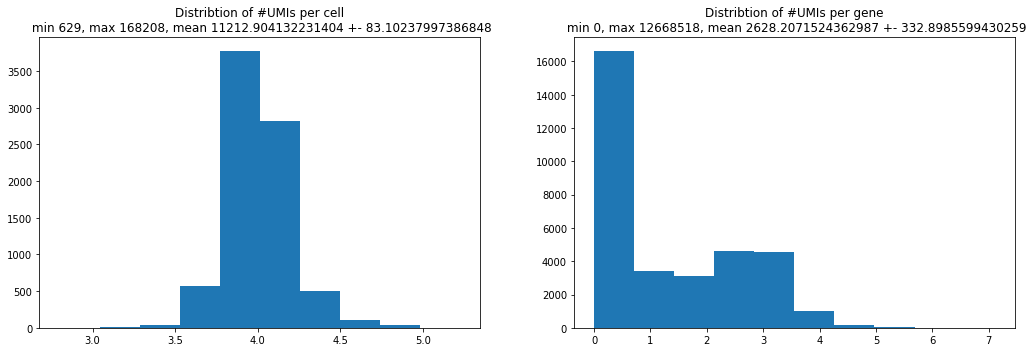

In [4]:
f, ax = plt.subplots(1,2,figsize=(15,5))
per_cell_sum = mat.sum(axis=1)
ax[0].hist(np.log10(per_cell_sum+1));
ax[0].set_title('Distribtion of #UMIs per cell\n min {}, max {}, mean {} +- {}'.format(min(per_cell_sum), 
                                                                               max(per_cell_sum), np.mean(per_cell_sum),
                                                                               np.sqrt(np.std(per_cell_sum))));
per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1));
ax[1].set_title('Distribtion of #UMIs per gene\n min {}, max {}, mean {} +- {}'.format(min(per_gene_sum), 
                                                                               max(per_gene_sum), np.mean(per_gene_sum),
                                                                               np.sqrt(np.std(per_gene_sum))));
plt.tight_layout()

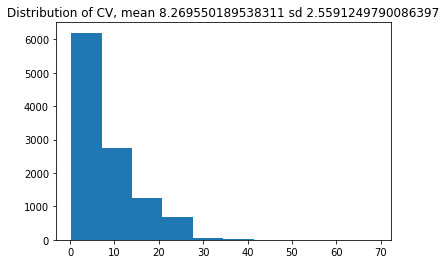

In [5]:
low_expr_thr = 100
high_expr_thr  = 100000
mat = mat[:,(per_gene_sum>=low_expr_thr) & (per_gene_sum<=high_expr_thr)] #just remove extreme outliers
mean_exp = mat.mean(axis=0)
std_exp = np.sqrt(mat.std(axis=0))
CV = std_exp/mean_exp
plt.hist(CV);
plt.title('Distribution of CV, mean {} sd {}'.format(np.mean(CV), np.std(CV)**0.5));

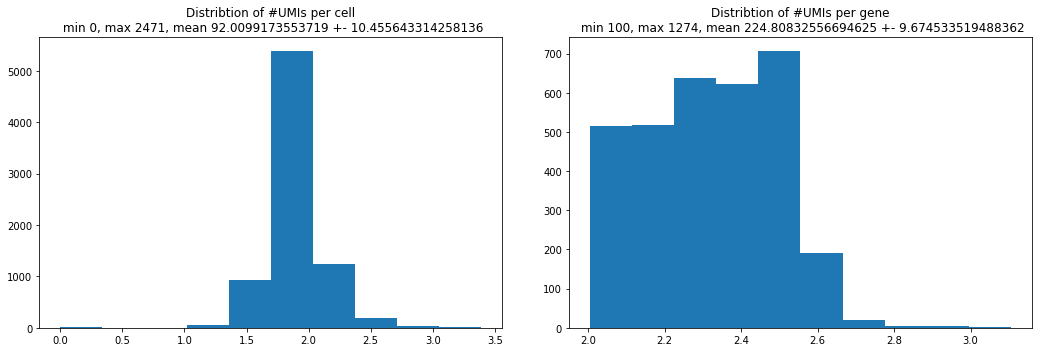

In [6]:
mat = mat[:,CV>=10]
f, ax = plt.subplots(1,2,figsize=(15,5))
per_cell_sum = mat.sum(axis=1)
ax[0].hist(np.log10(per_cell_sum+1));
ax[0].set_title('Distribtion of #UMIs per cell\n min {}, max {}, mean {} +- {}'.format(min(per_cell_sum), 
                                                                               max(per_cell_sum), np.mean(per_cell_sum),
                                                                               np.sqrt(np.std(per_cell_sum))));
per_gene_sum = mat.sum(axis=0)
ax[1].hist(np.log10(per_gene_sum+1));
ax[1].set_title('Distribtion of #UMIs per gene\n min {}, max {}, mean {} +- {}'.format(min(per_gene_sum), 
                                                                               max(per_gene_sum), np.mean(per_gene_sum),
                                                                               np.sqrt(np.std(per_gene_sum))));
plt.tight_layout()

In [7]:
cells_expression = mat.sum(axis=1)
mat = mat[cells_expression>=100,:]
mat = np.log(mat+1)

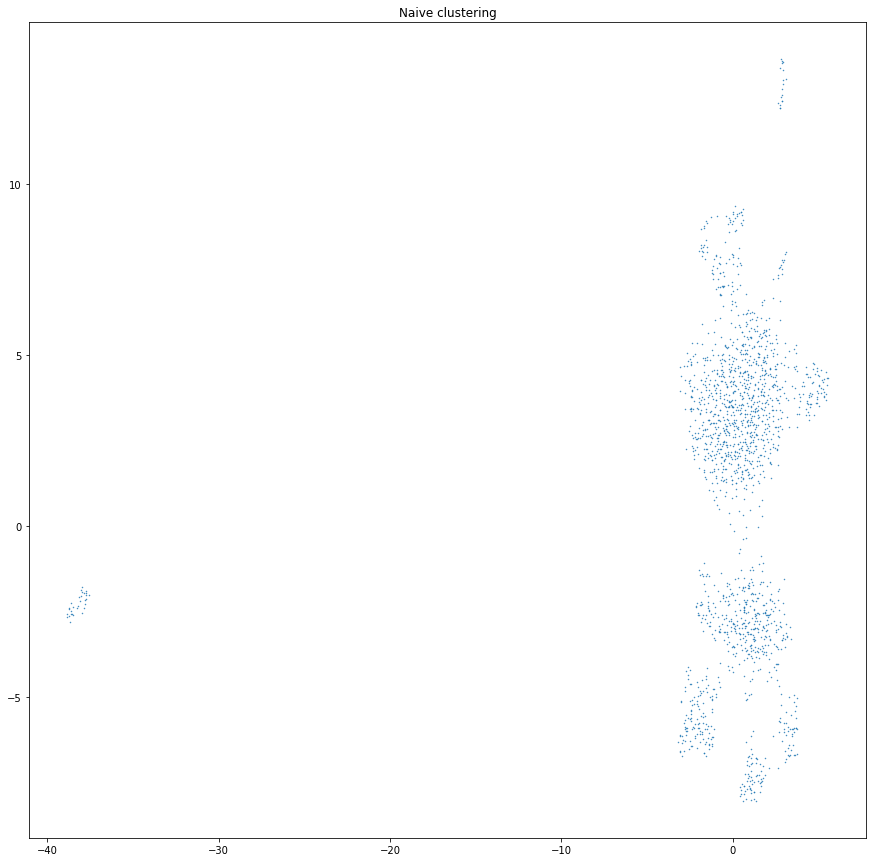

In [8]:
pca = PCA(n_components=100)
pca.fit(mat)
mat_reduce = pca.transform(mat)
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.5,
                      metric='euclidean').fit_transform(mat_reduce.astype(np.float32, order='A'))
plt.figure(figsize=(15,15))
plt.scatter(embedding[:,0],embedding[:,1],s=0.2);
plt.title('Naive clustering'); 

/usr/local/lib/python3.5/dist-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.5/dist-packages/sklearn/cluster/hierarchical.py:193: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')
/usr/local/lib/python3.5/dist-packages/sklearn/cluster/hierarchical.py:426: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  affinity=affinity)
/usr/local/lib/python3.5/dist-packages/sklearn/cluster/birch.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result 

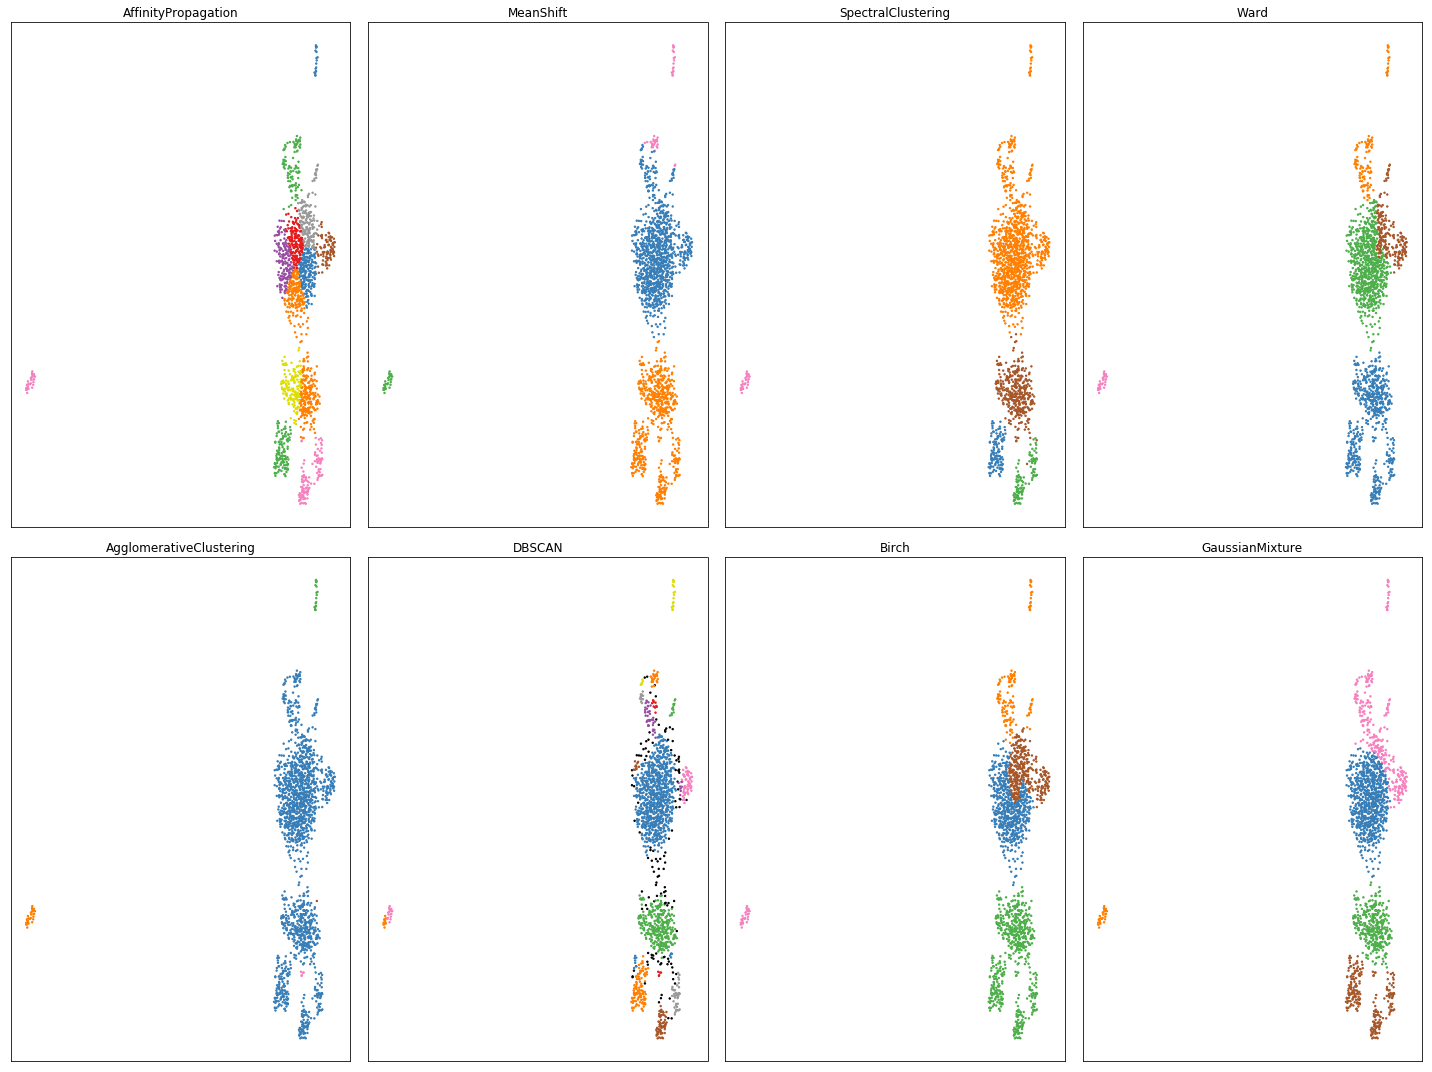

In [9]:
params = {'quantile': .3,
          'eps': .3,
          'damping': .9,
          'preference': -200,
          'n_neighbors': 10,
          'n_clusters': 5}
bandwidth = estimate_bandwidth(embedding, quantile=params['quantile'])
connectivity = kneighbors_graph(
        embedding, n_neighbors=params['n_neighbors'], include_self=False)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ward = AgglomerativeClustering(
    n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
spectral = SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
dbscan = DBSCAN(eps=params['eps'])
affinity_propagation = AffinityPropagation(
    damping=params['damping'], preference=params['preference'])
average_linkage = AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
birch = Birch(n_clusters=params['n_clusters'])
gmm = GaussianMixture(n_components=params['n_clusters'], covariance_type='full')
clustering_algorithms = (
    ('AffinityPropagation', affinity_propagation),
    ('MeanShift', ms),
    ('SpectralClustering', spectral),
    ('Ward', ward),
    ('AgglomerativeClustering', average_linkage),
    ('DBSCAN', dbscan),
    ('Birch', birch),
    ('GaussianMixture', gmm))
#now plot everything
f, ax = plt.subplots(2, 4, figsize=(20,15))
for idx, (name, algorithm) in enumerate(clustering_algorithms):
    algorithm.fit(embedding)
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(embedding)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    ax[idx//4, idx%4].scatter(embedding[:, 0], embedding[:, 1], s=2, color=colors[y_pred])
    #ax[idx//4, idx%4].xlim(-2.5, 2.5)
    #ax[idx//4, idx%4].ylim(-2.5, 2.5)
    ax[idx//4, idx%4].set_xticks(())
    ax[idx//4, idx%4].set_yticks(())
    ax[idx//4, idx%4].set_title(name)

plt.tight_layout()